# 3. Семинар -- ценообразование

# imports

In [ ]:
import numpy as np
from scipy.stats import truncnorm
import random
import pandas as pd

from tabulate import tabulate

from sklearn.model_selection import train_test_split
import lightgbm

from functools import partial
from tabulate import tabulate

import statsmodels.formula.api as smf
import statsmodels.api as sm

from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")
colors = sns.color_palette()

%matplotlib inline

# Вспомогательные функции

In [ ]:
def get_demand_metrics(df, date_column):
    df_dmetrics = df.groupby('product_id').agg(
        date_min=(date_column, 'min'),
        date_max=(date_column, 'max'),
        n_demands=(date_column, 'nunique'),
        demand_std=('sales_units', 'std'),
        demand_mean=('sales_units', 'mean'))

    df_dmetrics['cv2'] = np.power(df_dmetrics['demand_std'] / df_dmetrics['demand_mean'], 2.0)
    time_delta = df_dmetrics['date_max'] - df_dmetrics['date_min']
    if pd.api.types.is_numeric_dtype(time_delta):
        df_dmetrics['adi'] = time_delta / df_dmetrics['n_demands']
    else:
        df_dmetrics['adi'] = time_delta.dt.days / df_dmetrics['n_demands']

    conditions = [
        (df_dmetrics['cv2'] <= 0.49) & (df_dmetrics['adi'] <= 1.32),
        (df_dmetrics['cv2'] <= 0.49) & (df_dmetrics['adi'] >  1.32),
        (df_dmetrics['cv2'] >  0.49) & (df_dmetrics['adi'] <= 1.32)
    ]
    choices = ['smooth', 'intermittent', 'erratic']
    df_dmetrics['type'] = np.select(conditions, choices, default='lumpy')

    return df_dmetrics

def plot_demand_type(df_demand_metrics):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.scatter(df_demand_metrics['cv2'], df_demand_metrics['adi'], alpha = 0.5)
    ax.axhline(1.32, linestyle='--', color='k')
    ax.axvline(0.49, linestyle='--', color='k')
    ax.set_xlim([-0.1, 1.5])
    ax.set_xlabel('CV2')
    ax.set_ylabel('ADI')
    plt.show()


# Highlight weekends on a time series chart
def highlight_weekends(ax, color='k', alpha=0.1):
    ax.set_ylim(*ax.get_ylim())
    xmin, xmax = ax.get_xlim()
    days = np.arange(np.floor(xmin), np.ceil(xmax) + 2)
    weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
    ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor=color, alpha=alpha)
    ax.set_xlim(xmin, xmax)

# Custom dataframe printing function
def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')

# Эластичность

Пусть имеем линейный спрос
$$
q(p) = a - bp,
$$
где a, b оцениваем по данным, p -- цена.

Эластичность определяется так
$$
ɛ(p)=-\frac{\Delta q / q}{\Delta p / p}=-\frac{∂q}{\partial p}\cdot \frac{p}{q}
$$
Тогда для линейного спроса получаем
$$
ɛ(p)=\frac{bp}{a-bp}
$$

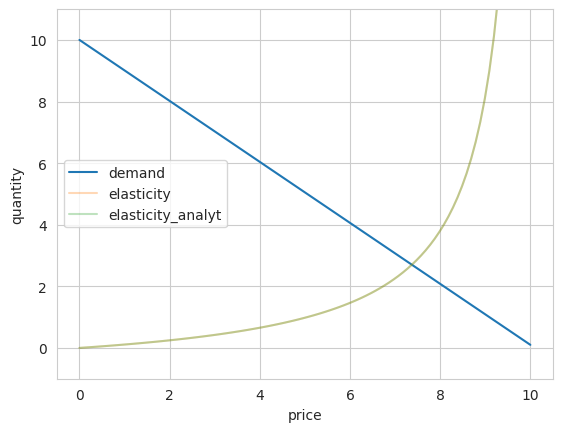

In [ ]:
# та самая точечная эластичность
def empirical_elasticity(p, q):
    e = np.zeros(len(q))
    for i in range(1, len(q)):
        e[i] = -(q[i] - q[i-1])/(p[i] - p[i-1]) * (p[i] / q[i])
    return e

def lin_dem_elastcity(p, a, b):
    return b * p / (a - b * p)

# задаем линейную функцию спроса
a, b = 10, 0.99
demand_function = lambda p: a - b*p

p = np.linspace(0, 10, 100)
plt.plot(p, demand_function(p), label='demand')
plt.plot(p, empirical_elasticity(p, demand_function(p)), label='elasticity', alpha=0.3)
plt.plot(p, lin_dem_elastcity(p, a, b), label='elasticity_analyt', alpha=0.3)
plt.grid(True);
plt.xlabel('price');
plt.ylabel('quantity');
plt.legend();
plt.ylim([-1, a+1]);

Постоянная эластичность.

При постоянной эластичности спрос имеет вид
$$
q(p) = ap^{-ɛ}.
$$

Проверим, что это так
$$
\frac{\partial q}{\partial p} = -ɛap^{-ɛ-1},
$$
$$
\frac{\partial q}{\partial p}\cdot \frac pq = -ɛap^{-ɛ-1} \cdot \frac{p}{ap^{-ɛ}} = ɛ.
$$

Говорят, что спрос неэластичный при $|ɛ| < 1$ (при изменении цены спрос меняется незначительно) и, наоборот, спрос эластичный при $|ɛ| > 1$.

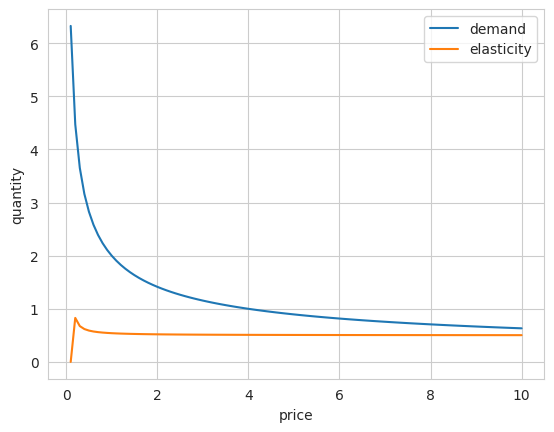

In [ ]:
# спрос с постоянной эластичностью
epsilon = -0.5
demand_function = lambda p: 2*np.power(p, epsilon)

p = np.linspace(0.1, 10, 100)
plt.plot(p, demand_function(p), label='demand')
plt.plot(p, empirical_elasticity(p, demand_function(p)), label='elasticity')
# plt.plot(p, [epsilon] * len(p), label='elasticity')
plt.grid(True);
plt.xlabel('price');
plt.ylabel('quantity');
plt.legend();

# Данные для примера

Возьмем данные с kaggle.

Подробнее тут https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [ ]:
orders = pd.read_csv('/content/ecommerce-sales-orders.csv.zip',
                     compression='zip',
                     parse_dates=['date'])
orders['year'] = orders['date'].dt.year.astype(np.int32)
orders['week'] = orders['date'].dt.isocalendar().week.astype(np.int32)
orders['date'] = pd.to_datetime(orders['date'].dt.date, format='%Y-%m-%d')

order_items = pd.read_csv('/content/ecommerce-sales-order-items.csv.zip',
                          compression='zip',
                          parse_dates=[])

items = pd.read_csv('/content/ecommerce-sales-products.csv.zip',
                    compression='zip')

In [ ]:
orders.head(3)

,date,order_id,year,week
0,2017-10-02,0,2017,40
1,2018-07-24,1,2018,30
2,2018-08-08,2,2018,32


In [ ]:
order_items.head(3)

,price,product_id,order_id
0,58.9,0,85267
1,55.9,0,64197
2,64.9,0,10214


In [ ]:
items.head(3)

,category_name,product_id,category_id
0,perfumery,30587,0
1,perfumery,1544,0
2,perfumery,8819,0


# Data preparation

In [ ]:
df = order_items.merge(orders, on='order_id', how='inner')
df['sales_units'] = 1
df.drop(columns=['order_id'], inplace=True)
df = df.groupby(['product_id', 'date']).agg({'price': 'max',
                                             'year': 'max',
                                             'week': 'max',
                                             'sales_units': 'sum'}).reset_index()

print('Unique products:', len(df['product_id'].unique()))

Unique products: 32951


In [ ]:
df.head(3)

,product_id,date,price,year,week,sales_units
0,0,2017-06-05,55.9,2017,23,1
1,0,2017-06-28,55.9,2017,26,1
2,0,2017-07-27,55.9,2017,30,1


Отрисуем объемы и цены продаж по времени для конкретного товара.

In [ ]:
# топ 3 товаров с разными ценами
df.groupby(['product_id']).agg({'price': 'nunique'}).sort_values('price', ascending=False)[:3]

,price
product_id,
249,27
262,27
884,26


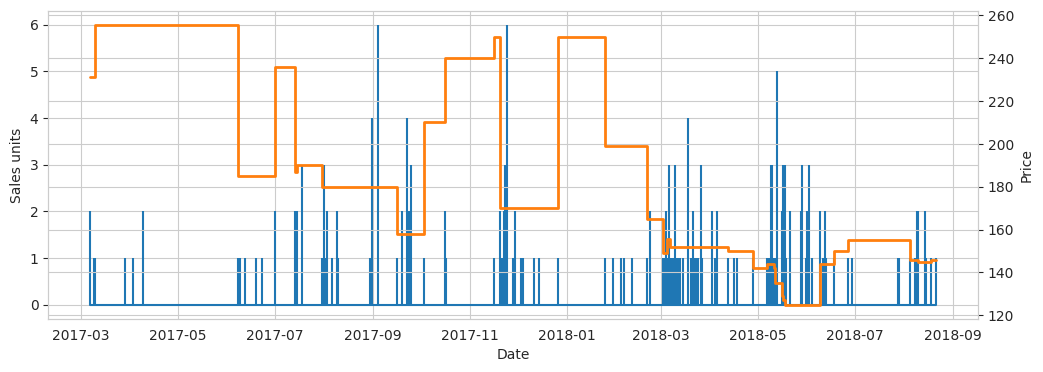

In [ ]:
example_product_id = 249
fig, ax1 = plt.subplots(1, figsize=(12, 4))
df_example_prod = df.query('product_id == @example_product_id')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sales units')
ax1.stem(df_example_prod['date'],
         df_example_prod['sales_units'],
         linefmt='C0',
         markerfmt='none',
         basefmt='C0',
         label='Sales')
plt.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Price')
ax2.step(df_example_prod['date'],
         df_example_prod['price'],
         color='C1',
         where='post',
         linewidth=2,
         label='Price')

In [ ]:
# товары с продажами на горизонте 10+ дней
df_week_counts = df\
    .groupby(['product_id', 'year', 'week'])\
    .size()\
    .reset_index()
df_active_products = df_week_counts\
    .groupby(['product_id'])\
    .size()\
    .reset_index(name='active_weeks')\
    .query('active_weeks >= 10')
df_active = df\
    .merge(df_active_products['product_id'],
           on='product_id',
           how='inner')

print('Unique products:', len(df_active['product_id'].unique()))

Unique products: 1193


In [ ]:
df_active.head(3)

,product_id,date,price,year,week,sales_units
0,4,2017-02-04,199.9,2017,5,1
1,4,2017-04-25,199.9,2017,17,1
2,4,2017-05-04,199.9,2017,18,1


In [ ]:
# немного терминологии по метрикам, которые будут использоваться

The average inter-demand interval (ADI) is a measure of demand sparsity that is defined as the average distance between two nonzero demand intervals. For a time series of length n, the ADI can be calculated simply as
$$ADI = \frac{n}{k}$$  where k is the number of demand buckets, which are the inter-
vals with consecutive nonzero demand values.

The squared coefficient of variation (CV2) is a measure of the demand magnitude variance. It is defined as the ratio between the variance $σ^2_q$ and squared empirical mean $E[q]$ of the demand series:
$$CV^2 = \left(\frac{σ_q}{E[q]}\right)^2$$

/content/cv_adi_pict.png

In [ ]:
df_dmetrics = get_demand_metrics(df_active, 'date')
df_dmetrics.head(3)

,date_min,date_max,n_demands,demand_std,demand_mean,cv2,adi,type
product_id,,,,,,,,
4,2017-02-04,2018-03-10,12,0.000000,1.000000,0.000000,33.250000,intermittent
10,2017-07-16,2018-06-29,48,0.460785,1.145833,0.161716,7.250000,intermittent
12,2017-02-28,2018-08-19,268,1.247324,1.820896,0.469233,2.003731,intermittent


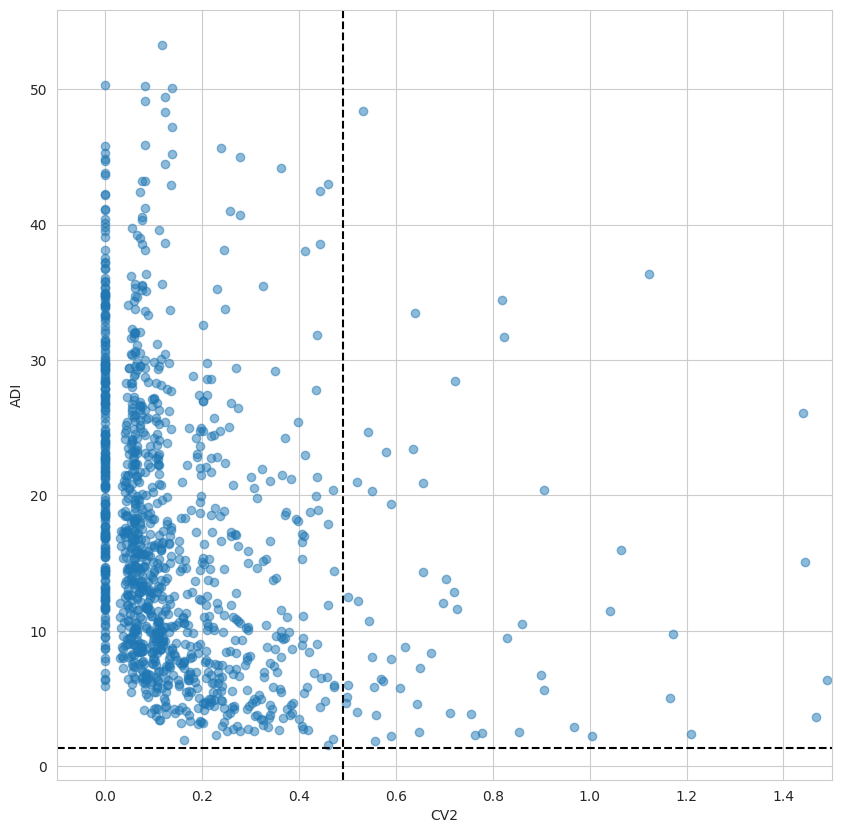

In [ ]:
plot_demand_type(df_dmetrics)

In [ ]:
non_lumpy_products = df_dmetrics.query("type != 'lumpy'").index
df_active_nonlumpy = df_active[df_active['product_id'].isin(non_lumpy_products)]

print('Unique products:', len(df_active_nonlumpy['product_id'].unique()))

Unique products: 1132


In [ ]:
df_active_nonlumpy.head(3)

,product_id,date,price,year,week,sales_units
0,4,2017-02-04,199.9,2017,5,1
1,4,2017-04-25,199.9,2017,17,1
2,4,2017-05-04,199.9,2017,18,1


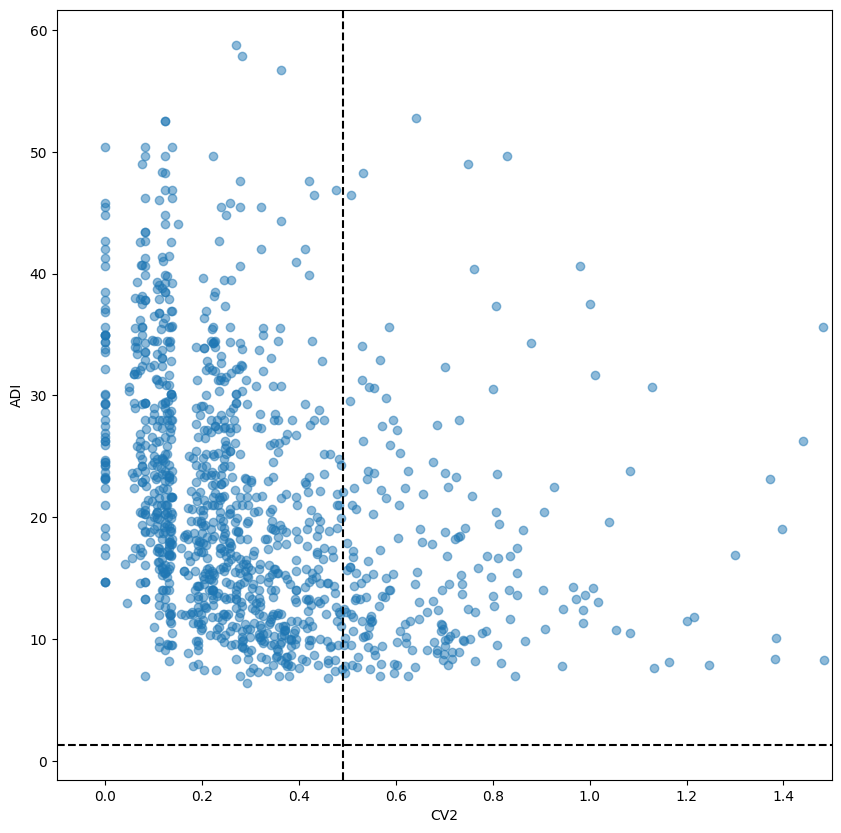

Unique products: 970


In [ ]:
# Сделаем недельную агрегацию

df_weekly = df_active.copy()

# Date is the week start date
df_weekly['date'] = pd.to_datetime(df_weekly['date']).dt.to_period('W').dt.start_time
df_weekly = df_weekly\
    .groupby(['product_id', 'date'])\
    .agg({'sales_units': 'sum', 'price': 'mean'})\
    .reset_index()

df_dmetrics = get_demand_metrics(df_weekly, 'date')
plot_demand_type(df_dmetrics)

non_lumpy_products_weekly = df_dmetrics.query("type != 'lumpy'").index
df_active_nonlumpy_weekly = df_weekly[df_weekly['product_id'].isin(non_lumpy_products_weekly)]

print('Unique products:', len(df_active_nonlumpy_weekly['product_id'].unique()))

In [ ]:
# - Товары с 6+ разными ценами
# - Товары с продажми 15+ недель
df_active_variable_products = df_active_nonlumpy_weekly\
    .groupby('product_id')\
    .agg(n_prices = ('price', 'nunique'),
         n_weeks = ('date', 'nunique'))\
         .query('n_prices >= 6 & n_weeks >= 15')
df_active_variable = df_active_nonlumpy_weekly[df_active_nonlumpy_weekly['product_id'].isin(df_active_variable_products.index)]

df_active_variable = df_active_variable\
    .merge(items,
           on='product_id',
           how='left')

print('Unique products:', len(df_active_variable['product_id'].unique()))

NameError: name 'df_active_nonlumpy_weekly' is not defined

In [ ]:
df_active_variable.head(3)

,product_id,date,sales_units,price,category_name,category_id
0,109,2017-06-05,1,119.9,health_beauty,13
1,109,2017-06-19,1,119.9,health_beauty,13
2,109,2017-06-26,2,119.9,health_beauty,13


# Прогнозирование спроса и анализ эластичности (бустинг)

In [ ]:
# немного фичей для обучения модели, можно что-то поменять для эксперимента
df_tmp = df_active_variable\
    .groupby(['product_id'])['sales_units']\
    .shift(1)\
    .rolling(1)\
    .mean()\
    .reset_index()
df_lags = df_active_variable.\
    join(df_tmp\
         .rename(columns={'sales_units':'sales_lag'})\
         .drop(columns=['index']))

X = df_lags[['product_id', 'category_id', 'date', 'price', 'sales_lag']]
y = df_lags[['sales_units']]

X['year'] = pd.to_datetime(X['date']).dt.year
X['month'] = pd.to_datetime(X['date']).dt.month
X['week'] = pd.to_datetime(X['date']).dt.isocalendar().week.astype(np.int32)
X['price_log'] = np.log(X['price'])
X.drop(columns=['date', 'price'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-16-28b14f387f78>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['year'] = pd.to_datetime(X['date']).dt.year


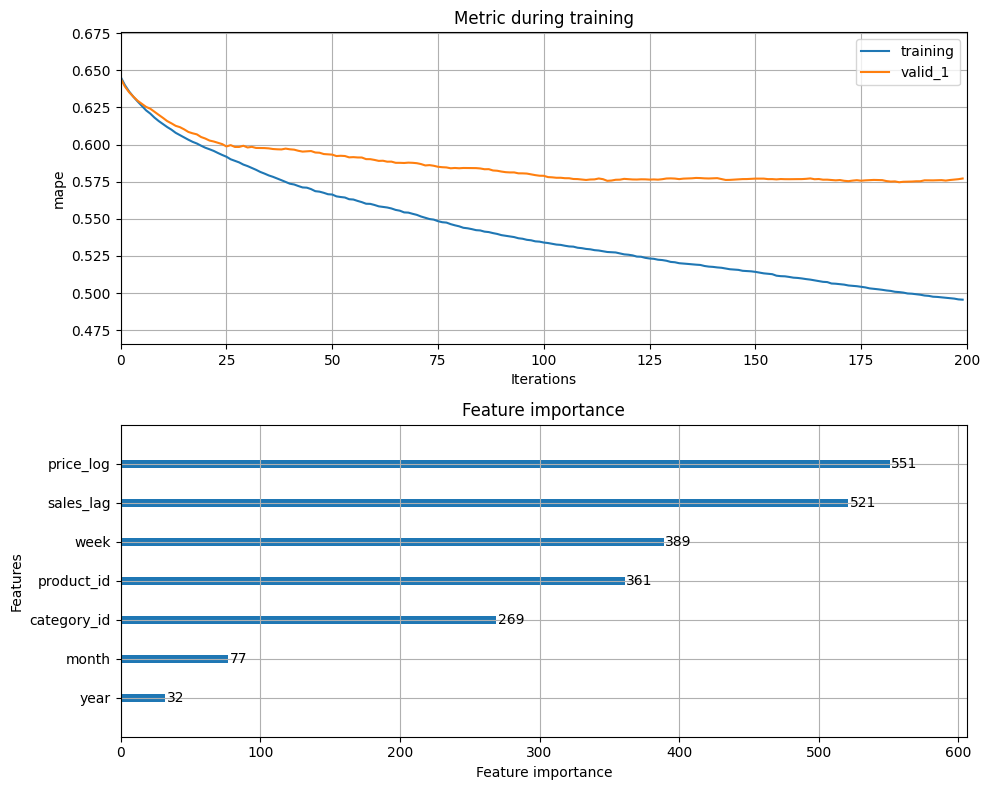

In [ ]:
# обучаем модель, смотрим ошибки и фичи
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': ['mse', 'mape'],
    'num_leaves': 12,
    'learning_rate': 0.05,
    'verbosity': -1
}

ds_train = lightgbm.Dataset(X_train, y_train)
ds_test = lightgbm.Dataset(X_test, y_test)

evals_result = {}
model = lightgbm.train(
              params = params,
              train_set = ds_train,
              valid_sets = [ds_train, ds_test],
              num_boost_round = 200,
              callbacks=[lightgbm.record_evaluation(evals_result)]
)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
lightgbm.plot_metric(evals_result, metric='mape', ax=ax[0])
lightgbm.plot_importance(model, ax=ax[1])
plt.tight_layout()

plt.show()

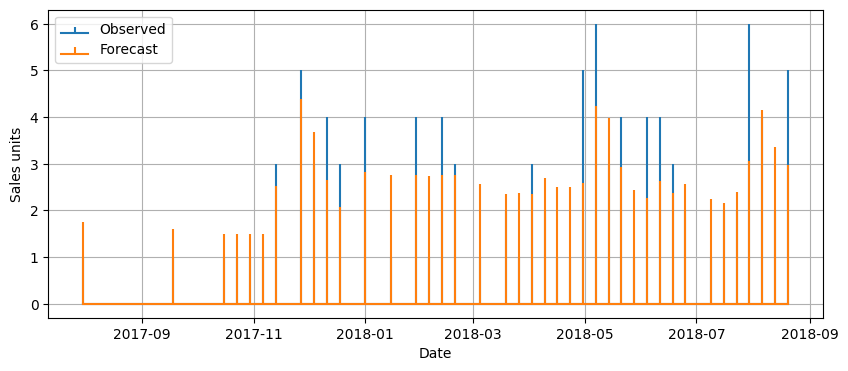

In [ ]:
# посмотрим на конкретный товар
example_product_id = 216
X_validate = X.query('product_id == @example_product_id')
sales_units_hat = model.predict(X_validate)
sales_units = df_active_variable.query('product_id == @example_product_id')

forecast = X_validate.copy()
forecast['sales_units_hat'] = sales_units_hat
forecast['sales_units'] = sales_units['sales_units']
forecast['price'] = sales_units['price']
forecast['date'] = sales_units['date']

fig, ax = plt.subplots(1, figsize=(10, 4))
ax.stem(forecast['date'], forecast['sales_units'], linefmt='C0', markerfmt='none', basefmt='C0', label='Observed')
ax.stem(forecast['date'], forecast['sales_units_hat'], linefmt='C1', markerfmt='none', basefmt='C1', label='Forecast')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales units')
ax.grid(True)


Text(0, 0.5, 'Sales units')

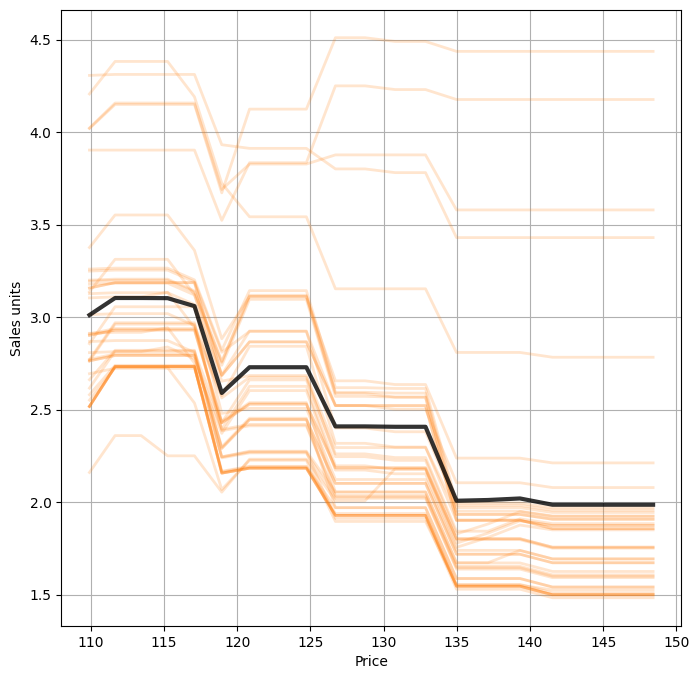

In [ ]:
# с помощью модели спроса построим кривую эластичности для товара
fig, ax = plt.subplots(1, figsize=(8, 8))

item_log_prices = X.query('product_id == @example_product_id')['price_log']
price_logs = np.linspace(item_log_prices.min(), np.ceil(item_log_prices.max()), 20)
market_responses = []
for x in np.array(X.query('product_id == @example_product_id')):
    X_validate = []
    for price_log in price_logs:
        X_validate.append(x.copy())
        X_validate[-1][-1] = price_log

    X_validate = np.array(X_validate)

    sales_units_hat = model.predict(X_validate)
    market_responses.append(sales_units_hat)

    ax.plot(np.exp(price_logs), sales_units_hat, color='C1', linewidth=2, alpha=0.2)

ax.plot(np.exp(price_logs), np.mean(market_responses, axis=0), color='k', linewidth=3, alpha=0.8)

ax.grid(True)
ax.set_xlabel('Price')
ax.set_ylabel('Sales units')

# Прогнозирование спроса с помощью GLM

Допустим у нас есть исторические данные продаж нескольких товаров. Для каждого товара у нас есть временной ряд продаж и допольнительные ковариаты, например, цена. Допускаем, что товары могут влиять друг на друга, т.е. что-то типа каннибализации.

Оценим влияние изменения цены на спрос и построим прогноз спроса.
Будем использовать обобщенные линейные модели (GLM). Такой подход позволяет не только прогнозировать спрос, но и получать интерпретацию влияния ковариат на целевую переменную.
Построим 2 модели:

* агрегированную модель -- log(item_1_demand) ~ log(item_1_price)
* модель временного ряда с лагами и календарными фичами -- log(item_1_demand_t) ~ log(item_1_price_t) + log(item_2_price_t) + is_weekend + ...

Будем использовать синтетические данные для чистоты эксперимента.

## Создадим синтетический набор данных

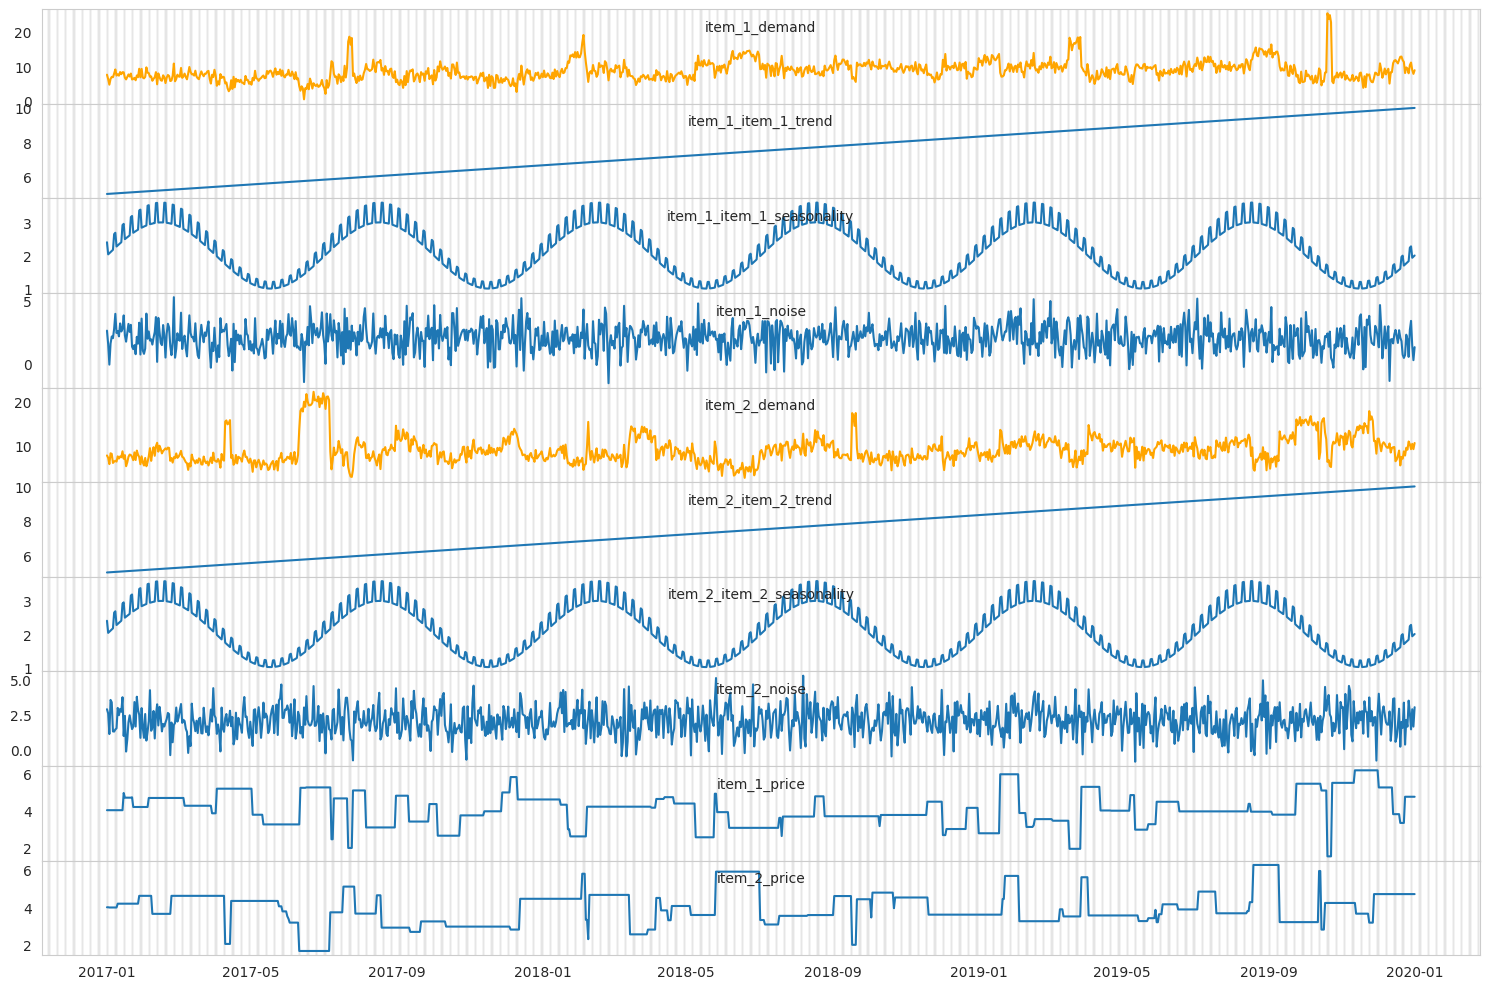

In [ ]:
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s


# Covariate effect functions

def multiplicative_effect(x, z, a):
    """
    Multiplicative power-law effect of a covariate z on x

    Compute element-wise y = x * z^a where a is a scalar, and x and z are vectors.
    This equivalent to log(y) = a * log(z) + log(x)
    """
    return x * np.power(z, np.full_like(z, a))

def additive_effect(x, z, b):
    """
    Simple additive effect of a covariate z on x
    """
    return x + b*z


# Data generation function
def create_data(demand_spec, start_date, end_date):
    idx = pd.date_range(start=start_date, end=end_date, freq='D')
    df = pd.DataFrame(index=idx, dtype=float)
    n = len(df.index)

    # Generate covariates
    covariates = {}
    for name, func in demand_spec['covariates'].items():
        covariates[name] = func(n)

    for item_id, spec in demand_spec['items'].items():
        base_components = {}
        for cname, func in spec['base'].items():
            component = np.zeros(n)
            for i in range(n):
                component[i] = func(idx, i)
            base_components[f'{item_id}_{cname}'] = component

        # Synthesize the baseline demand
        demand = np.sum(list(base_components.values()), axis=0)

        # Apply covariate effects
        for cov_name, effect_func in spec['covariates'].items():
            demand = effect_func(demand, covariates[cov_name])

        # Add noise
        noise = [spec['noise'](idx, i) for i in range(n)]
        demand += noise

        df[f'{item_id}_demand'] = demand
        for comp_name, c in base_components.items():
            df[f'{item_id}_{comp_name}'] = c
        df[f'{item_id}_noise'] = noise

    for cov_name, covariate_series in covariates.items():
        df[cov_name] = covariate_series

    return df


# Generation parameters
def seasonal_component(date_idx, i):
    days_year, quarters_year = 365, 4
    s = 2.0 + np.sin(np.pi * i/days_year*quarters_year)
    if date_idx[i].dayofweek > 4:
        s *= 1.2

    return s


# Предполагаем, что собственные цены товаров имеют положительный мультипликативный эффект
# а другие цены оказывают отрицательный эффект, т.н. каннибализация
demand_spec = {
    "covariates": { # covariates can be shared across the items
        "item_1_price": partial(step_series, mean=4, scale=1.0, n_steps=80),
        "item_2_price": partial(step_series, mean=4, scale=1.0, n_steps=80)
    },
    "items": {
        "item_1": {
            "base": {
                "trend": lambda date_idx, i: 5 + 5.0 * i/len(date_idx),
                "seasonality": seasonal_component
            },
            "covariates": {
                "item_1_price": partial(multiplicative_effect, a=-1.1),  # own price
                "item_2_price": partial(multiplicative_effect, a=+0.8)   # cannibalization
            },
            "noise": lambda date_ix, i: 2 + np.random.randn(1)[0]
        },
        "item_2": {
            "base": {
                "trend": lambda date_idx, i: 5 + 5.0 * i/len(date_idx),
                "seasonality": seasonal_component
            },
            "covariates": {
                "item_2_price": partial(multiplicative_effect, a=-1.2),  # own price
                "item_1_price": partial(multiplicative_effect, a=+0.9)   # cannibalization
            },
            "noise": lambda date_ix, i: 2 + np.random.randn(1)[0]
        }
    }
}

n_items = len(demand_spec['items'])

np.random.seed(seed=42)
df = create_data(demand_spec, start_date='2017-01-01', end_date='2020-01-01')
_, ax = plt.subplots(len(df.columns), figsize=(15, 10), sharex=True, gridspec_kw={'hspace': 0})
for i, c in enumerate(df.columns):
    color = None
    if 'demand' in c:
        color = 'orange'
    ax[i].plot(df.index, df[c], c=color)
    ax[i].set_title(c, y=0.8, va="top")
    ax[i].title.set_size(10)
    ax[i].grid()
    highlight_weekends(ax[i])

plt.tight_layout()
plt.show()

## Немного EDA

Посмотрим на распределения и корреляции

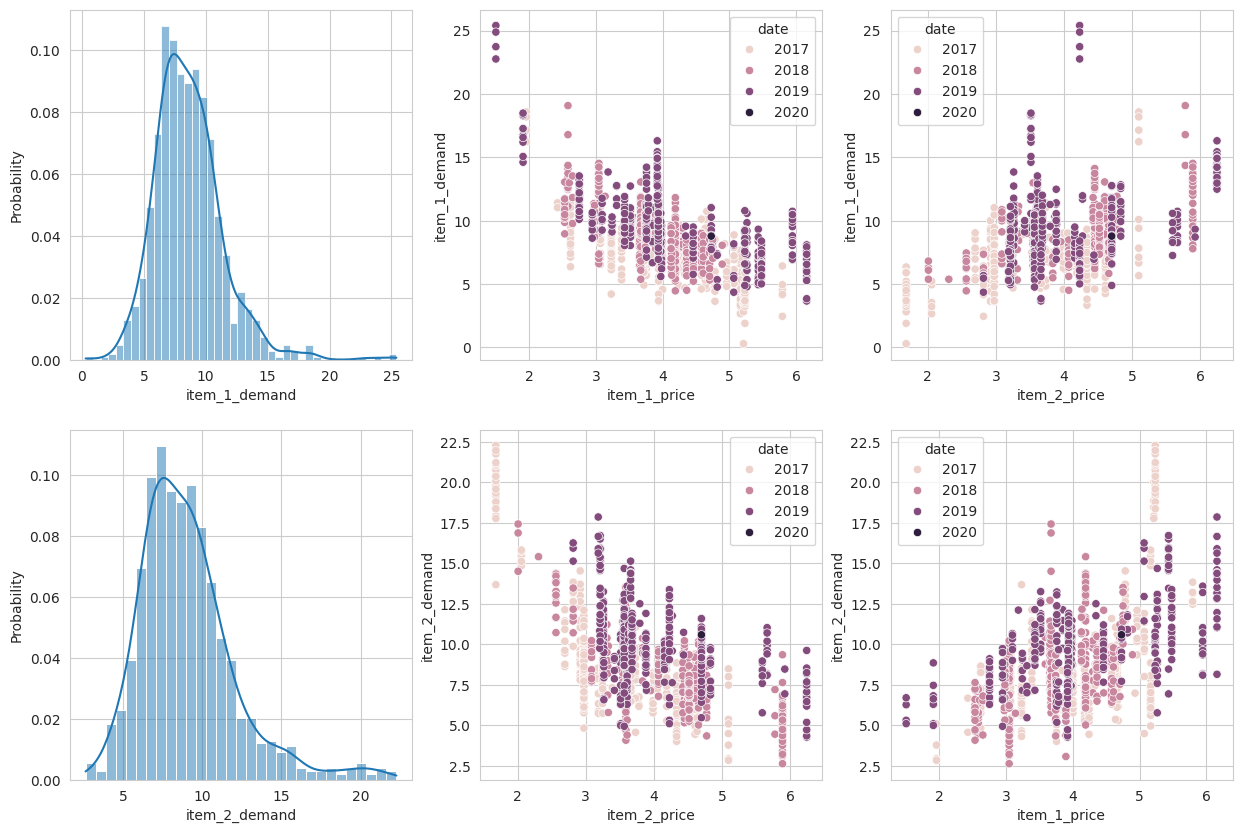

In [ ]:
df_vis = df.rename_axis('date').reset_index()
df_vis['date'] = df_vis['date'].dt.year

_, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(n_items):
    sns.histplot(data=df_vis, x=f'item_{i+1}_demand', kde=True, stat='probability', ax=ax[i][0])
    sns.scatterplot(data=df_vis, y=f'item_{i+1}_demand', x=f'item_{i+1}_price', hue='date', ax=ax[i][1])
    sns.scatterplot(data=df_vis, y=f'item_{i+1}_demand', x=f'item_{2-i}_price', hue='date', ax=ax[i][2])

## Создадим фичи

In [ ]:
def compute_features(data, item_id, all_items):
    df = data.rename_axis('date').reset_index()

    demand = df[f'{item_id}_demand']
    demand_lags = pd.concat(
        [df[f'{item_id}_demand'].shift(1, fill_value=np.mean(demand))],
        axis=1,
        keys=[f'{item_id}_demand_lag1']
    )

    calendar = pd.concat([
        df['date'].dt.year - np.min(df['date'].dt.year),
        (df['date'].dt.dayofweek > 4).astype(int),
        df['date'].dt.quarter
    ], axis=1, keys= [
        'year',
        'is_weekend',
        'quarter'
    ])

    own_price = pd.concat([ df[f'{item_id}_price'] ], axis=1)
    avg_price = pd.DataFrame(pd.concat([ df[f'{id}_price'] for id in all_items ], axis=1).mean(axis=1), columns=['avg_price'])

    df_xy = pd.concat([demand, demand_lags, own_price, avg_price, calendar], axis=1)Ага, а в сл

    return df_xy

all_items = list(demand_spec['items'].keys())
df_xy = compute_features(df, 'item_1', all_items)
df_xy.head()

,item_1_demand,item_1_demand_lag1,item_1_price,avg_price,year,is_weekend,quarter
0,7.482076,8.614096,4.0,4.000000,0,1,1
1,6.162749,7.482076,4.0,4.000000,0,0,1
2,4.565075,6.162749,4.0,3.994208,0,0,1
3,6.264401,4.565075,4.0,3.994208,0,0,1
4,6.849151,6.264401,4.0,3.994208,0,0,1


## Price-Response Model



In [ ]:
def fit_response_model(data, item_id):
    formula_price = f'{item_id}_demand ~ np.log({item_id}_price)'
    return smf.glm(formula=formula_price,
                   data=data,
                   family=sm.families.Gaussian(sm.families.links.Log())).fit()

df_xy = compute_features(df, 'item_1', all_items)
response_model = fit_response_model(df_xy, 'item_1')
print(response_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          item_1_demand   No. Observations:                 1096
Model:                            GLM   Df Residuals:                     1094
Model Family:                Gaussian   Df Model:                            1
Link Function:                    Log   Scale:                          3.9051
Method:                          IRLS   Log-Likelihood:                -2300.7
Date:                Thu, 29 Feb 2024   Deviance:                       4272.2
Time:                        12:58:13   Pearson chi2:                 4.27e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5984
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.3510 

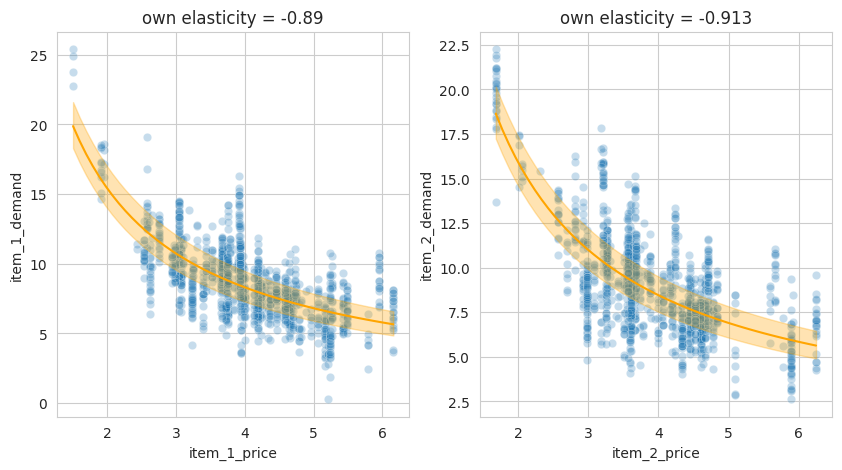

In [ ]:
def demand_function(x, e, b):
    return np.exp(b + e * np.log(x))

_, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, item_id in enumerate(all_items):
    df_xy = compute_features(df, item_id, all_items)
    m = fit_response_model(df_xy, item_id)
    c = m.params

    x = np.linspace(min(df_xy[f'{item_id}_price']), max(df_xy[f'{item_id}_price']), num=50)
    b_mean, e_mean = c['Intercept'], c[f'np.log({item_id}_price)']
    y = demand_function(x, e_mean, b_mean)
    sns.scatterplot(data=df_xy, y=f'{item_id}_demand', x=f'{item_id}_price',  alpha=0.25, ax=ax[i])
    sns.lineplot(x=x, y=y, ax=ax[i], c='orange')

    # Confidence intervals
    conf_int = m.conf_int(alpha=0.05)
    e_conf_int = conf_int.loc[f'np.log({item_id}_price)']
    e_lower, e_upper = e_conf_int[0], e_conf_int[1]
    b_conf_int = conf_int.loc[f'Intercept']
    b_lower, b_upper = b_conf_int[0], b_conf_int[1]
    y_lower, y_upper = demand_function(x, e_lower, b_lower), demand_function(x, e_upper, b_upper)
    ax[i].fill_between(x, y_lower, y_upper, alpha=0.3, color='orange')

    ax[i].set_title(f'own elasticity = {e_mean:.3}')

## Time Series Model

In [ ]:
item_id = 'item_1'
n_holdout = 100

# Input data preparation
df_xy = compute_features(df, item_id, all_items)
df_train, df_test = df_xy[:-n_holdout], df_xy[-n_holdout:]

formula_all = f"""
{item_id}_demand ~ np.log({item_id}_price)
                 + np.log(avg_price)
                 + np.log({item_id}_demand_lag1)
                 + year
                 + is_weekend
                 + C(quarter)
"""
model_all = smf.glm(formula=formula_all,
                    data=df_train,
                    family=sm.families.Gaussian(sm.families.links.Log())).fit()
print(model_all.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          item_1_demand   No. Observations:                  996
Model:                            GLM   Df Residuals:                      987
Model Family:                Gaussian   Df Model:                            8
Link Function:                    Log   Scale:                          1.1972
Method:                          IRLS   Log-Likelihood:                -1498.4
Date:                Thu, 29 Feb 2024   Deviance:                       1181.6
Time:                        13:10:50   Pearson chi2:                 1.18e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9903
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
item_id

'item_1'

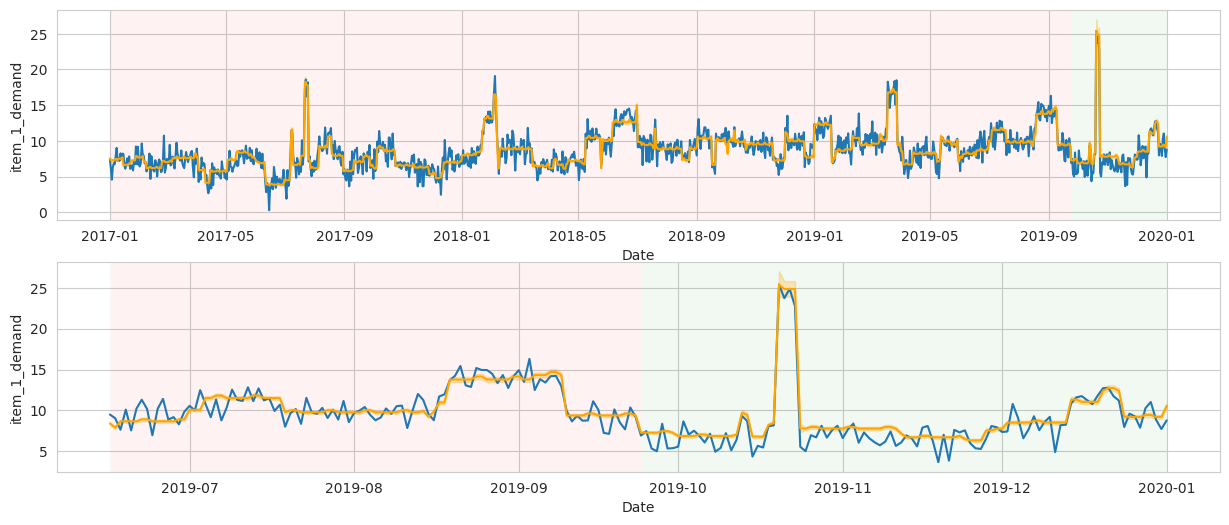

In [ ]:
# In-sample forecasting
in_sample_forecast = model_all.get_prediction(df_train).summary_frame()

# Out-of-sample forecasting: one-step-ahead recursive approach
out_of_sample_forecast = []
demand_t1 = df_train.iloc[-1][f'{item_id}_demand']
for t in range(n_holdout):
    x = pd.DataFrame([df_test.iloc[t]])
    x.iloc[0][f'{item_id}_demand_lag1'] = demand_t1
    y_t = model_all.get_prediction(x).summary_frame(alpha=0.05).iloc[0]
    out_of_sample_forecast.append(y_t)
    demand_t1 = y_t['mean']

# Concatenate the in/out-of-sample forecasts
forecast = pd.concat([in_sample_forecast, pd.DataFrame(out_of_sample_forecast)])

def plot_forecast(ax, x, y_true, y_forecast, n_holdout):
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{item_id}_demand')
    ax.grid(True)
    ax.axvspan(x[0], x[-n_holdout], facecolor='red', alpha=0.05)
    ax.axvspan(x[-n_holdout], x[-1], facecolor='green', alpha=0.05)
    ax.plot(x, y_true, c=colors[0])
    ax.plot(x, y_forecast['mean'], c='orange')
    ax.fill_between(x, y_forecast['mean_ci_lower'], y_forecast['mean_ci_upper'], color='orange', alpha=0.25)


# Plotting the entire range and
date_index = df.index
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
plot_forecast(ax[0], date_index, df_xy[f'{item_id}_demand'], forecast, n_holdout)
plot_forecast(ax[1], date_index[-2*n_holdout:], df_xy[f'{item_id}_demand'][-2*n_holdout:], forecast[-2*n_holdout:], n_holdout)

эксперимент с ценами

In [ ]:
x.head()

,item_1_demand,item_1_demand_lag1,item_1_price,avg_price,year,is_weekend,quarter
1095,8.781169,9.197568,4.727833,4.713463,3.0,0.0,1.0


In [ ]:
item_prices = np.linspace(min(df_xy[f'{item_id}_price']), max(df_xy[f'{item_id}_price']), num=50)
out_of_sample_forecast_prices = []
demand_t1 = df_train.iloc[-1][f'{item_id}_demand']
for t in range(n_holdout):
    x = pd.DataFrame([df_test.iloc[t]])
    x.iloc[0][f'{item_id}_demand_lag1'] = demand_t1
    for item_price in item_prices:
        x.iloc[0]['avg_price'] = (x.iloc[0]['avg_price']*2 - x.iloc[0][f'{item_id}_price'] + item_price)*0.5
        x.iloc[0][f'{item_id}_price'] = item_price
        y_t = model_all.get_prediction(x).summary_frame(alpha=0.05).iloc[0]
        y_t['price'] = item_price
        out_of_sample_forecast_prices.append(y_t)
        # out_of_sample_forecast_prices = out_of_sample_forecast_prices\
                                            # .append(pd.DataFrame.from_series(y_t), ignore_index=True)
    break
    demand_t1 = y_t['mean']

In [ ]:
tmp = pd.concat(out_of_sample_forecast_prices, axis=1).transpose()

<Axes: xlabel='price', ylabel='mean'>

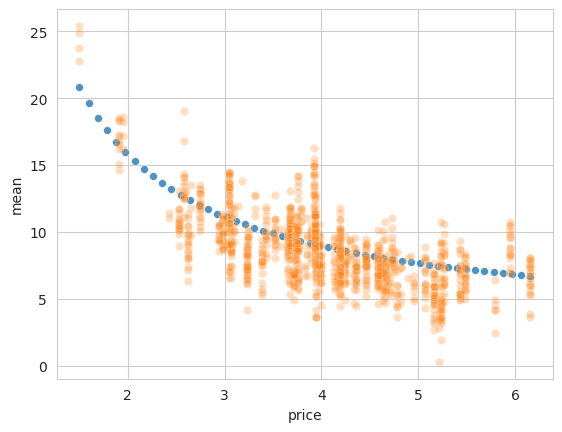

In [ ]:
sns.scatterplot(y='mean', x='price', data=tmp, s=32, alpha=.8)
sns.scatterplot(data=df_xy, y=f'{item_id}_demand', x=f'{item_id}_price',  alpha=0.25)
# plt.gca().spines[['top', 'right',]].set_visible(False)

# Жадный алгоритм + сэмплирование

In [ ]:
def demand_func(p, epsilon=-1, a=1e4):
    return np.round(a*np.power(p, epsilon))

EPS = -2.5
COSTS = 1
def actual_profit(p, c=COSTS):
    return demand_func(p, epsilon=EPS)*(p-c)*truncnorm.rvs(a=0.1, b=1, loc=1, scale=0.2)

def actual_profit_vect(p, c=COSTS):
    return np.vectorize(actual_profit)(p, c)

In [ ]:
prices = np.round(np.linspace(1, 10, 500, dtype=float), 2)
demands = np.zeros_like(prices)
demands = actual_profit_vect(prices, c=COSTS)
# y = []
# for price in prices:
#     y.append(R(price, c=500))

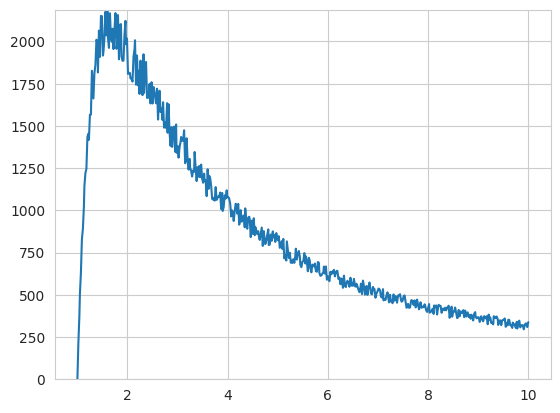

In [ ]:
fig = plt.figure()
plt.plot(prices, demands)
# plt.plot(prices, y)
plt.ylim(0, demands.max() + 10);

In [ ]:
prices[np.argmax(demands)]

1.74

Вспомогательные функции

In [ ]:
from sklearn.linear_model import LinearRegression


def nearest(lst, target):
    return min(lst, key=lambda x: abs(x-target))


def estimate_profit(p, epsilon, a, c):
    return demand_func(p, epsilon, a)*(p-c)


def opt_price_const_el(epsilon, cost):
    return np.round(-epsilon * cost / (-epsilon - 1.), 2)


def init_sampling(func_demand, prices_bins, n=5):
    x = []
    y = []
    for _ in range(n):
        tmp_x = np.random.choice(prices_bins)
        y.append(func_demand(tmp_x))
        x.append(tmp_x)
    return x, y


def get_opt_params(x, y, elast=False):
    # logq = loga - elogp
    x = np.array(x)
    y = np.array(y)
    if not elast:
        y = y / (x - COSTS)
    est = LinearRegression(n_jobs=-1)
    est.fit(np.log(x).reshape(-1, 1), np.log(y))
    return est.coef_[0], np.exp(est.intercept_)

In [ ]:
opt_price_const_el(EPS, COSTS), actual_profit(opt_price_const_el(EPS, COSTS))

(1.67, 2119.3526409720766)

# Алгоритмы

In [ ]:
prices_exp = np.round(np.linspace(1.05, 10, 20, dtype=float), 2)
prices_exp, nearest(prices_exp, opt_price_const_el(EPS, COSTS)), demand_func(opt_price_const_el(EPS, COSTS), EPS)

(array([ 1.05,  1.52,  1.99,  2.46,  2.93,  3.41,  3.88,  4.35,  4.82,
         5.29,  5.76,  6.23,  6.7 ,  7.17,  7.64,  8.12,  8.59,  9.06,
         9.53, 10.  ]),
 1.52,
 2775.0)

In [ ]:
x, y = init_sampling(actual_profit, prices_exp, 5)

In [ ]:
x, y

([3.41, 7.64, 2.93, 9.53, 1.99],
 [1293.3517797838158,
  493.7361509520411,
  1515.2794399816203,
  323.4069926506148,
  2008.5248952955794])

Жадный алгоритм.

$ɛ$ -- параметр, с помощью которого мы пробуем новые цены.

В $(1 - ɛ)$% случаев используется та ручка, которая приносит в среднем больше прибыли.

Можем менять $ɛ$ во времени.


## Greedy

In [ ]:
# random sampling
def rsampling(x, y, bins, num_iter=10):
    x_res = x.copy()
    y_res = y.copy()
    for _ in range(num_iter):
        tmp_x = np.random.choice(bins)
        tmp_y = actual_profit(tmp_x)
        x_res.append(tmp_x)
        y_res.append(tmp_y)
    return x_res, y_res


# greedy
def egreedy(x, y, bins, k=0.2, num_iter=10):
    x_res = x.copy()
    y_res = y.copy()
    for _ in range(num_iter):
        if np.random.rand() < k:
            tmp_x = np.random.choice(bins)
            x_res.append(tmp_x)
            tmp_y = actual_profit(tmp_x)
            y_res.append(tmp_y)
        else:
            tmp_e, tmp_a = get_opt_params(x_res, y_res)
            tmp_x = opt_price_const_el(tmp_e, COSTS)
            tmp_x = nearest(bins, tmp_x)
            x_res.append(tmp_x)
            tmp_y = actual_profit(tmp_x)
            y_res.append(tmp_y)
    print(f'e = {tmp_e}, a = {tmp_a}')
    return x_res, y_res

In [ ]:
n = 100
x_rs, y_rs = rsampling(x, y, prices_exp, n)
x_eg, y_eg = egreedy(x, y, prices_exp, k=0.2, num_iter=n)

e = -2.50174330865507, a = 10992.710156433757


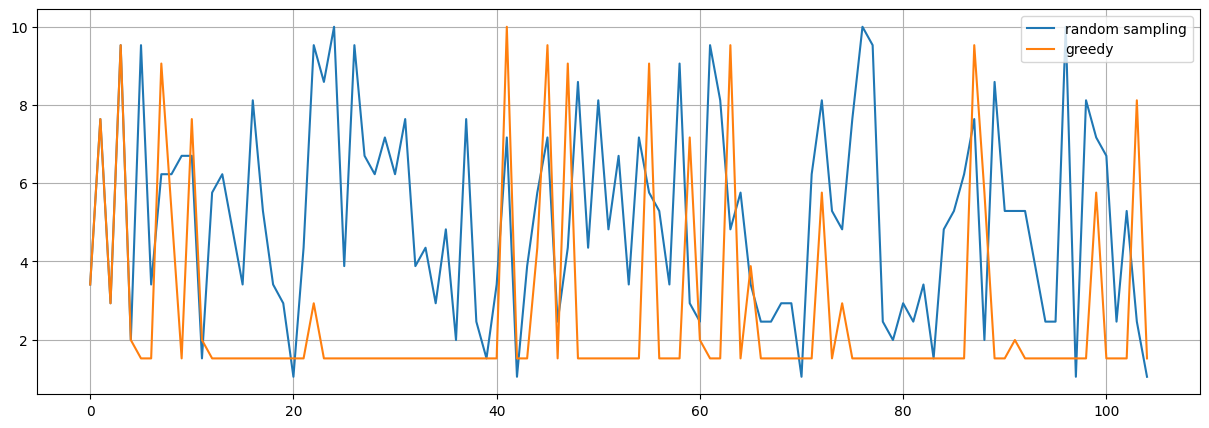

In [ ]:
plt.figure(figsize=(15, 5));
plt.grid(True);
plt.plot(x_rs, label='random sampling')
plt.plot(x_eg, label='greedy')
plt.legend();

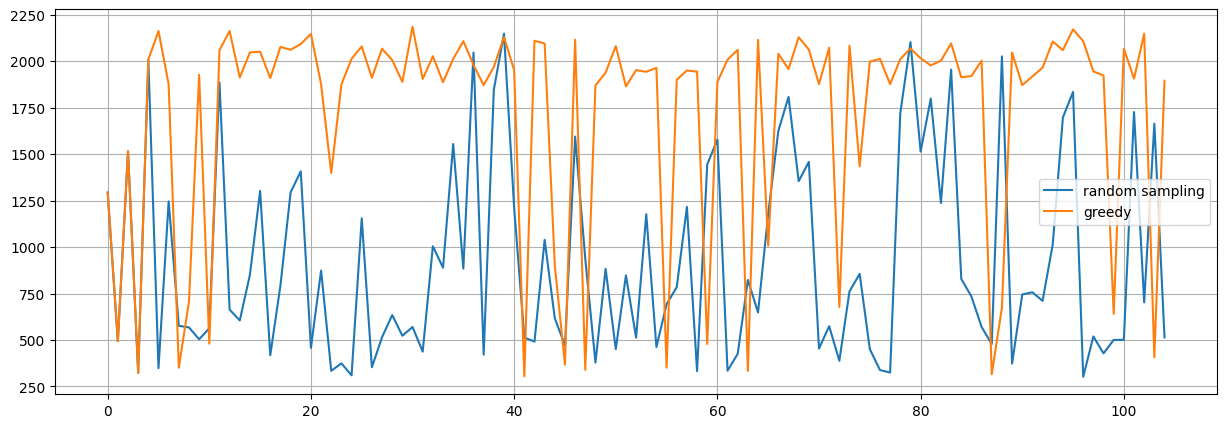

In [ ]:
plt.figure(figsize=(15, 5));
plt.grid(True);
plt.plot(y_rs, label='random sampling')
plt.plot(y_eg, label='greedy')
plt.legend();

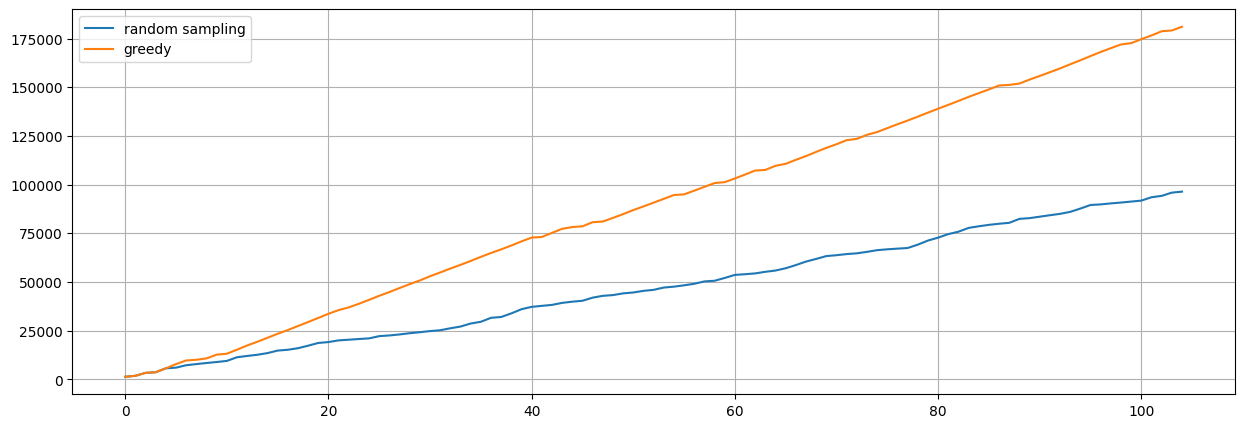

In [ ]:
plt.figure(figsize=(15, 5));
plt.grid(True);
plt.plot(np.cumsum(y_rs), label='random sampling')
plt.plot(np.cumsum(y_eg), label='greedy')
plt.legend();

## Thompson Sampling

Предположим, что у нас не связаны цены, тогда для каждого уровня будем считать, что
$$
d_i - poisson(\theta_i)
$$
Априорным распределением для $\theta$ можем выбрать гамма распределение, тк оно является сопряженным для Пуассоновского.
$$
q(\theta) = gamma(α, β) = \frac{β^α}{Γ(α)}\theta^{α-1}e^{-β\theta}
$$
Пусть цена $p_i$ реализовывалась $n$ раз с объемом $d_i$, тогда правдоподобие можно записать так
$$
q(d|\theta) = ∏_{i=1}^{n}\frac{e^{-\theta}\theta^{d_i}}{d_i!} = \frac{e^{-n\theta}\theta^{\sum_i d_i}}{∏_i d_i!}
$$
Правило для обновления постериорного распределения (произведение априорного и правдоподобия)
$$
q(\theta) ← q(\theta) \cdot q(d|\theta) = gamma(\alpha + \sum d_i, \beta + n)
$$

Алгоритм.


*   Задаем начальные параметры для гамма распределений $(α_i, \beta_i)$

Далее на каждой итерации:


*   Сэмплируем $d_i$ из $q_i(\theta)$
*   Ищем оптимальну цену $p^*$
*   Выставляем $p^*$ и собираем реальный $d^*$
*   Обновляем параметры для этой цены
$$
\alpha_j ← \alpha_j + d^*,\\
\beta_j ← \beta_j + 1
$$







In [ ]:
from scipy.optimize import linprog
import scipy.stats as stats
from tabulate import tabulate

In [ ]:
def optimal_price_probabilities(revenues):
    L = len(revenues)
    M = np.full([1, L], 1)
    B = [[1]]

    res = linprog(-np.array(revenues).flatten(),
                  A_eq=M,
                  b_eq=B,
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    return price_prob

In [ ]:
tmp = np.argmax(optimal_price_probabilities(np.array(y_eg)))
print(x_eg[tmp])

1.52


In [ ]:
# prior distribution for each price - gamma(α, β)
theta = []
for p in prices_exp:
    # theta.append({'price': p, 'alpha': 500.00, 'beta': 1.00, 'mean': 500.00})
    tmp_e, tmp_a = get_opt_params(x, y) # elast & a
    cur_val = np.round(demand_func(p, epsilon=tmp_e, a=tmp_a) + np.random.randint(100))
    theta.append({'price': p, 'alpha': cur_val, 'beta': 1.00, 'mean': cur_val})
print(theta)


def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)


def sample_demands_from_model(theta):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), theta))

T = 100
history = []
y_ts = y.copy()
for t in range(0, T):              # simulation loop
    demands = sample_demands_from_model(theta)
    # print(tabulate(np.array(theta), tablefmt="fancy_grid"))

    # print("demands = ", np.array(demands))
    revenue = np.multiply(prices_exp - COSTS, demands)
    price_probs = optimal_price_probabilities(revenue)

    # select one best price
    price_index_t = np.random.choice(len(prices_exp), 1, p=price_probs)[0]
    price_t = prices_exp[price_index_t]

    # sell at the selected price and observe demand
    demand_t = demand_func(price_t, epsilon=EPS)
    # demand_t = np.random.poisson(demand_t, 1)[0]
    revenue_t = actual_profit(price_t)
    y_ts.append(revenue_t)
    # print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, revenue_t))

    theta_trace = []
    for v in theta:
        theta_trace.append(v.copy())
    history.append([price_t, demand_t, revenue_t, theta_trace])

    # update model parameters
    v = theta[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']

[{'price': 1.05, 'alpha': 10362.0, 'beta': 1.0, 'mean': 10362.0}, {'price': 1.52, 'alpha': 4095.0, 'beta': 1.0, 'mean': 4095.0}, {'price': 1.99, 'alpha': 2072.0, 'beta': 1.0, 'mean': 2072.0}, {'price': 2.46, 'alpha': 1247.0, 'beta': 1.0, 'mean': 1247.0}, {'price': 2.93, 'alpha': 828.0, 'beta': 1.0, 'mean': 828.0}, {'price': 3.41, 'alpha': 554.0, 'beta': 1.0, 'mean': 554.0}, {'price': 3.88, 'alpha': 391.0, 'beta': 1.0, 'mean': 391.0}, {'price': 4.35, 'alpha': 343.0, 'beta': 1.0, 'mean': 343.0}, {'price': 4.82, 'alpha': 293.0, 'beta': 1.0, 'mean': 293.0}, {'price': 5.29, 'alpha': 254.0, 'beta': 1.0, 'mean': 254.0}, {'price': 5.76, 'alpha': 212.0, 'beta': 1.0, 'mean': 212.0}, {'price': 6.23, 'alpha': 175.0, 'beta': 1.0, 'mean': 175.0}, {'price': 6.7, 'alpha': 107.0, 'beta': 1.0, 'mean': 107.0}, {'price': 7.17, 'alpha': 92.0, 'beta': 1.0, 'mean': 92.0}, {'price': 7.64, 'alpha': 87.0, 'beta': 1.0, 'mean': 87.0}, {'price': 8.12, 'alpha': 125.0, 'beta': 1.0, 'mean': 125.0}, {'price': 8.59, 'a

In [ ]:
theta

[{'price': 1.05, 'alpha': 10362.0, 'beta': 1.0, 'mean': 10362.0},
 {'price': 1.52, 'alpha': 316574.0, 'beta': 90.0, 'mean': 3517.488888888889},
 {'price': 1.99, 'alpha': 19972.0, 'beta': 11.0, 'mean': 1815.6363636363637},
 {'price': 2.46, 'alpha': 2301.0, 'beta': 2.0, 'mean': 1150.5},
 {'price': 2.93, 'alpha': 828.0, 'beta': 1.0, 'mean': 828.0},
 {'price': 3.41, 'alpha': 554.0, 'beta': 1.0, 'mean': 554.0},
 {'price': 3.88, 'alpha': 391.0, 'beta': 1.0, 'mean': 391.0},
 {'price': 4.35, 'alpha': 343.0, 'beta': 1.0, 'mean': 343.0},
 {'price': 4.82, 'alpha': 293.0, 'beta': 1.0, 'mean': 293.0},
 {'price': 5.29, 'alpha': 254.0, 'beta': 1.0, 'mean': 254.0},
 {'price': 5.76, 'alpha': 212.0, 'beta': 1.0, 'mean': 212.0},
 {'price': 6.23, 'alpha': 175.0, 'beta': 1.0, 'mean': 175.0},
 {'price': 6.7, 'alpha': 107.0, 'beta': 1.0, 'mean': 107.0},
 {'price': 7.17, 'alpha': 92.0, 'beta': 1.0, 'mean': 92.0},
 {'price': 7.64, 'alpha': 87.0, 'beta': 1.0, 'mean': 87.0},
 {'price': 8.12, 'alpha': 125.0, 'bet

In [ ]:
500. * (1.52 - 1), 464. * (3.41 - 1)

(260.0, 1118.24)

In [ ]:
sample_demands_from_model(theta)

[464.35662428298,
 489.4558934274485,
 511.6988972956212,
 533.9054009461343,
 680.3772632825195,
 467.6436126016159,
 370.96193332865533,
 299.381612439196,
 261.22076102945283,
 233.71936286908831,
 190.1432836609688,
 185.71721282579335,
 172.43055348517763,
 160.75528252801217,
 161.96154236320783,
 126.73684157294873,
 123.21725773065681,
 108.67936932754859,
 107.80410363076524,
 110.91165542070087]

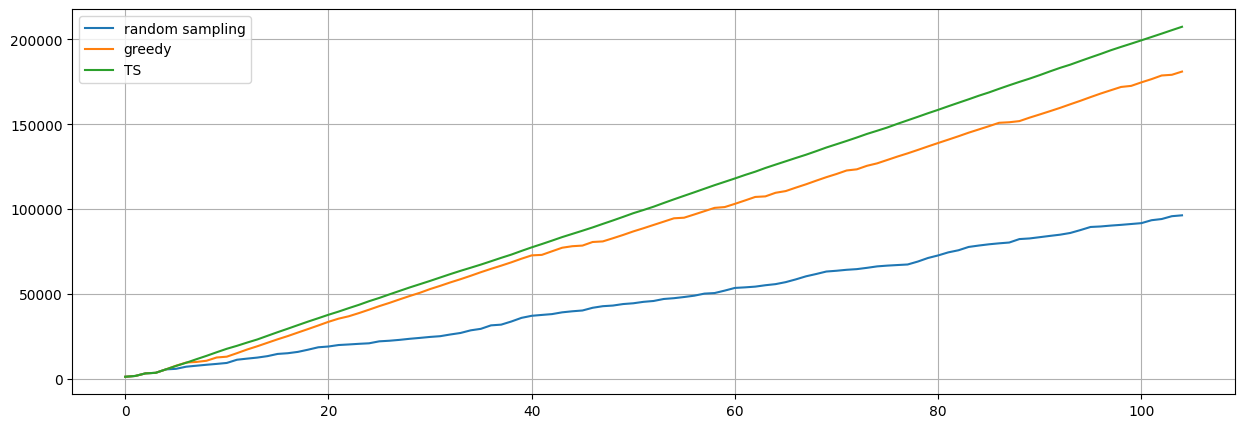

In [ ]:
plt.figure(figsize=(15, 5));
plt.grid(True);
plt.plot(np.cumsum(y_rs), label='random sampling')
plt.plot(np.cumsum(y_eg), label='greedy')
plt.plot(np.cumsum(y_ts), label='TS')
plt.legend();

In [ ]:
actual_profit(1.52)

1931.5200587904037

In [ ]:
print(tabulate(np.array(theta), tablefmt="fancy_grid"))

╒═══════╤════════╤════╤══════════╕
│  1.05 │  10040 │  1 │ 10040    │
├───────┼────────┼────┼──────────┤
│  1.52 │ 158422 │ 45 │  3520.49 │
├───────┼────────┼────┼──────────┤
│  1.99 │  12732 │  7 │  1818.86 │
├───────┼────────┼────┼──────────┤
│  2.46 │   1165 │  1 │  1165    │
├───────┼────────┼────┼──────────┤
│  2.93 │    749 │  1 │   749    │
├───────┼────────┼────┼──────────┤
│  3.41 │    510 │  1 │   510    │
├───────┼────────┼────┼──────────┤
│  3.88 │    368 │  1 │   368    │
├───────┼────────┼────┼──────────┤
│  4.35 │    276 │  1 │   276    │
├───────┼────────┼────┼──────────┤
│  4.82 │    213 │  1 │   213    │
├───────┼────────┼────┼──────────┤
│  5.29 │    168 │  1 │   168    │
├───────┼────────┼────┼──────────┤
│  5.76 │    135 │  1 │   135    │
├───────┼────────┼────┼──────────┤
│  6.23 │    111 │  1 │   111    │
├───────┼────────┼────┼──────────┤
│  6.7  │     92 │  1 │    92    │
├───────┼────────┼────┼──────────┤
│  7.17 │     78 │  1 │    78    │
├───────┼────────┼──

# Домашнее задание

Взять датасет либо на который была ссылка на семинаре (бразильский e-comm), либо из соревы m4 forecasting (там где ритейл), выбрать от 2 до 10 (по желанию) артикулов с большой частотой продаж и количеством различных цен 10+.
Попробовать для каждого построить кривую эластичности и сказать, годится ли такой товар для промо или лучше в регулярку

Затем попробовать сделать прогноз количества продаж на отложенный период 3 способами:
1. Без учёта цены на отложенной периоде
2. С учётом цены на будущем периоде в модели
3. С помощью комбинации модель + кривая спроса от цены + знание будущей цены.   
Сравнить результаты и провести анализ. Что зашло или нет и почему? Что можно улучшить?
